## TODO

- Create augmented dataset from all datasets
- Train on all datasets.
- Save dataset
- Freeze top layers
- Train lower layers on full dataset. 

In [87]:
import os
import random

import numpy as np
import cv2
from PIL import Image

import donkeybarn as barn

In [88]:
class AugmentPipeline:
    def __init__(self, data):
        self.data = data.copy()
        self.pipeline = []
        
    def add(self, processor, input_ix=[0, ], chance=.2):
        self.pipeline.append(
            {'processor': processor,
             'input_ix': input_ix,
             'chance': chance})
        
    def run(self, gen_count=None):
        
        if gen_count==None:
            gen_count = len(self.data)
            
        results = []
        
        #get row of data
        for i in range(gen_count): 
            row_num = np.random.randint(0,len(self.data))
            row = self.data[row_num].copy()
            
            #run row of data through pipeline
            for p in self.pipeline:
                
                #only run pipeline step if chance test succedes
                if p['chance'] > random.random():
            
                    #get inputs
                    inputs = []
                    for input_ix in p['input_ix']:
                        inputs.append(row[input_ix])
                    
                    #run processor
                    result = p['processor'].run(inputs)
                    
                    for i, output_ix in enumerate(p['input_ix']):
                        row[output_ix] = result[i]
            
            results.append(row)
        
        results = np.stack(results)        
        return results

In [110]:
class ToOneProcessor(barn.cv.augment.BaseProcessor):
    def run_arr(self, x):
        return 0
    
bp = barn.cv.augment.BaseProcessor()    
one = ToOneProcessor()

data = np.linspace(1,100,num=100).reshape((10,10))

apipe = AugmentPipeline(data)
apipe.add(bp,input_ix=[8], chance=1 )
apipe.add(one, input_ix=[2], chance=.6)
apipe.run()

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [71., 72., 73., 74., 75., 76., 77., 78., 79., 80.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [31., 32.,  0., 34., 35., 36., 37., 38., 39., 40.],
       [61., 62., 63., 64., 65., 66., 67., 68., 69., 70.],
       [11., 12.,  0., 14., 15., 16., 17., 18., 19., 20.],
       [71., 72., 73., 74., 75., 76., 77., 78., 79., 80.],
       [41., 42., 43., 44., 45., 46., 47., 48., 49., 50.],
       [51., 52., 53., 54., 55., 56., 57., 58., 59., 60.],
       [11., 12., 13., 14., 15., 16., 17., 18., 19., 20.]])

### Load Real Data

In [62]:
#location where to save datasets
data_dir = os.path.expanduser('~/donkey_data')

#track_data = barn.datasets.DriveaiLabeled.load(data_dir = data_dir)
track_data = barn.datasets.MakerFaireLabeled.load(data_dir = data_dir)
#load camera model to undistort and do birdseye perspective
fe = barn.cv.camera.FishEyeCamera(**barn.configs.donkey2_camera_params)

#load image labels
label_json_path = os.path.join(track_data.base_dir, 'labels.json')
data= barn.datasets.LabelBoxData(label_json_path)
data.gen_external_key_index()

File already exists.


### Calculate lane coefficients from labled data

In [74]:
X = []
for ix in range(len(track_data.img_paths)):
    img_name = os.path.basename(track_data.img_paths[ix])
    img = np.array(Image.open(track_data.img_paths[ix]))

    mask = np.array(data.get_mask_from_key(img_name, 'Center Line'))
    mask_undistorted = fe.undistort(mask)
    mask_birdseye = fe.birdseye(mask_undistorted)

    #output the coefficients of the line [c2, c1, c0] such that 
    # c2*x**2 + c1*x + c0 = y
    coef = barn.cv.lanes.find_line_coef_from_mask(mask_birdseye)
    X.append([img, coef])
    
X_arr = np.array(X)

#output [[img_arr, coef], ]
X_arr.shape

(281, 2)

###  Create the augmented training set

In [78]:
flp = barn.cv.augment.RandomFlip(func_on_flip=barn.cv.lanes.flip_line_coef)
rec = barn.cv.augment.RandomRectangles()
blur = barn.cv.augment.RandomBlur()
bright = barn.cv.augment.RandomBrightness()

# format (instance, mapping of array columns)
apipe = AugmentPipeline(X_arr)
apipe.add(flp, input_ix=[0,1], chance=.5)
apipe.add(rec, input_ix=[0], chance =.3)
apipe.add(blur, input_ix=[0], chance=.3)
X_aug = apipe.run(gen_count=100)

In [79]:
#separate the input and target datasets
Y = X_aug[:, 1]
X = X_aug[:, 0]
X.shape

(100,)

In [81]:
ix = 90
img = X[ix]
img_undist = fe.undistort(img)
img_birdseye = fe.birdseye(img_undist)
coef = Y[ix]
img_with_lines = barn.cv.draw.line_from_coef(img_birdseye, coef )

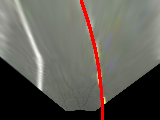

In [82]:
Image.fromarray(img_with_lines)

### confirm the the line was flipped 

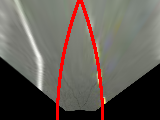

In [84]:
coef_rev = barn.cv.lanes.flip_line_coef(coef)
arr = barn.cv.draw.line_from_coef(img_birdseye, coef_rev)
arr = barn.cv.draw.line_from_coef(arr, coef)
Image.fromarray(arr)

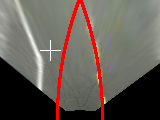

In [85]:
arr2 = cv2.drawMarker(arr, (50,50), color=(255,255, 255))
Image.fromarray(arr2)